# Fine-tuning on Pre-trained Model with Batch Integration
In this tutorial, we demonstrate how to fine-tune a pre-trained model on a new dataset for the batch integration task. We use the PBMC 10K dataset as an example and fine-tune on the pre-trained whole-body model. 

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on integration tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT


In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)


sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

Global seed set to 0
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-p

## Step1: Specify hyper-parameter setup for integration task
Here we provide some hyper-parameter recommendations here for the integration task. Note that the PBMC 10K dataset contains multiple batches to be integrated. Therefore, in addition to the default gene modelling objectives, we also turn on ESC, DAR and DSBN objectives specifically to faciliate batch integration.

In [2]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="clonotype_genes_filtered_counts_data", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="../model", # Path to pre-trained model
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0, # DAR objective weight for batch correction
    mask_ratio=0.4, # Default mask ratio
    epochs=10, # Default number of epochs for fine-tuning
    n_bins=501, # Default number of bins for value binning in data pre-processing
    lr=1e-4, # Default learning rate for fine-tuning
    batch_size=32, #64, # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
)

# wanbd.init put run_log in the wandb directory
run = wandb.init( 
    config=hyperparameter_defaults,
    project="batch_integration",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: kristint (mackall_lab). Use `wandb login --relogin` to force relogin


{'seed': 42, 'dataset_name': 'clonotype_genes_filtered_counts_data', 'do_train': True, 'load_model': '../model', 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'mask_ratio': 0.4, 'epochs': 10, 'n_bins': 501, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [3]:
import os
os.getcwd()

'/home/bench-user/scGPT/Tcell_GPT/tutorials'

In [4]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

In [5]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_clonotype_genes_filtered_counts_data-Jul16-19-45


## Step 2: Load and pre-process data

### 2.1 Load the merged dataset

In [6]:
from pathlib import Path
data_dir = Path("../../")
Tcell_data = sc.read_h5ad(data_dir/"Clono_MT_overlap_gene_filtered_merged_counts.h5ad") 

In [7]:
Tcell_data.obs["batch"] = Tcell_data.obs["sample_source"].astype("category")

In [8]:
Tcell_data.obs.batch.cat.categories


Index(['Good', 'Deng', 'Harad', 'Sheih'], dtype='object')

In [9]:
Tcell_data.obs.Response_3m.cat.categories
Tcell_data.obs["Response_3m"] = Tcell_data.obs["Response_3m"].astype("category")

In [10]:
Tcell_data.var['gene_symbols'] = Tcell_data.var.gene_name
Tcell_data.var


,gene_name,highly_variable,highly_variable_rank,means,variances,variances_norm,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,gene_symbols
1,FAM87B,True,4106.0,0.000040,0.000040,1.000080,False,1,0.000040,99.996011,1.0,FAM87B
2,LINC00115,False,NaN,0.014841,0.015658,0.859693,False,360,0.014841,98.563792,372.0,LINC00115
3,FAM41C,False,NaN,0.000439,0.000439,0.929125,False,11,0.000439,99.956116,11.0,FAM41C
4,SAMD11,False,NaN,0.000239,0.000239,0.953518,False,6,0.000239,99.976063,6.0,SAMD11
5,NOC2L,True,2040.0,0.531038,1.174560,1.145456,False,7863,0.531038,68.630815,13311.0,NOC2L
...,...,...,...,...,...,...,...,...,...,...,...,...
15350,FAM224B,False,NaN,0.001715,0.001792,0.901687,False,42,0.001715,99.832442,43.0,FAM224B
15351,TTTY14,False,NaN,0.004548,0.005166,0.944615,False,107,0.004548,99.573127,114.0,TTTY14
15352,KDM5D,False,NaN,0.076358,0.090718,0.967450,False,1698,0.076358,93.225884,1914.0,KDM5D
15353,TTTY10,False,NaN,0.005944,0.006149,0.855248,False,146,0.005944,99.417538,149.0,TTTY10


In [11]:

# method 1: randomly spliting
def ref_query_split(Tcell_data, seed_num, split_ratio):
    patient_list = Tcell_data.obs["patient_id"].unique()
    np.random.seed(seed_num)
    reference_patients = np.random.choice(patient_list, size=int(len(patient_list) * split_ratio), replace=False)
    reference_adata = Tcell_data[Tcell_data.obs['patient_id'].isin(reference_patients)]   
    query_adata = Tcell_data[~Tcell_data.obs['patient_id'].isin(reference_patients)]  
    return reference_adata, query_adata

In [12]:
ref_adata, query_adata = ref_query_split(Tcell_data, 1, 0.6)

In [13]:
ref_adata

View of AnnData object with n_obs × n_vars = 15380 × 15093
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'percent_mito', 'Response_3m', 'sample_source', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_symbols'
    uns: 'hvg'

In [14]:
if dataset_name == "clonotype_genes_filtered_counts_data":
    adata = ref_adata # 15380 × 15093
    ori_batch_col = "batch"
    adata.obs["Response_3m"] = adata.obs["Response_3m"].astype("category")
    adata.var = adata.var.set_index("gene_symbols")
    data_is_raw = True

# make the batch category column
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

### 2.2 Cross-check gene set with the pre-trained model 
Note that we retain the common gene set between the data and the pre-trained model for further fine-tuning.

In [15]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

scGPT - INFO - match 14986/15093 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../model/best_model.pt, the model args will be overriden by the config ../model/args.json.


### 2.3 Pre-process the data
We follow the standardized pipline of depth normalization, log normalization, and highly vairable gene (HVG) selection for data pre-processing. We further introduced value binning to obtain the relative expressions of each HVG.

In [16]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts= False, #3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch" if dataset_name != "heart_cell" else None)


scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


In [17]:
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

### 2.4 Tokenize the input data for model fine-tuning

In [18]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

response_labels = adata.obs["Response_3m"].tolist()  # make sure count from 0
num_types = len(set(response_labels))
response_labels = np.array(response_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_response_labels,
    valid_response_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, response_labels, batch_ids, test_size=0.1, shuffle=True
)


In [19]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [20]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)



scGPT - INFO - train set number of samples: 13842, 
	 feature length: 1201
scGPT - INFO - valid set number of samples: 1538, 
	 feature length: 1201


In [21]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

 ## Step 3: Load the pre-trained scGPT model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

model.to(device)
wandb.watch(model)

Use domain specific batchnorm with affine=False


[]

In [23]:
criterion = masked_mse_loss
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [24]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num


def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    response_labels = adata_t.obs["Response_3m"].tolist()
    response_labels = np.array(response_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["Response_3m"],
            title=[
                f"Response_3m, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["response_umap"] = fig

    if len(include_types) == 1:
        return results

## Step 4: Finetune scGPT with task-specific objectives

random masking at epoch   1, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   1 | 100/435 batches | lr 0.0001 | ms/batch 590.34 | loss 23554.64 | mse 13086.11 | mre 23055300.34 |gepc 10456.36 |
scGPT - INFO - | epoch   1 | 200/435 batches | lr 0.0001 | ms/batch 564.74 | loss 12447.34 | mse 6096.80 | mre 15065497.09 |gepc 6338.89 |
scGPT - INFO - | epoch   1 | 300/435 batches | lr 0.0001 | ms/batch 567.73 | loss 11083.55 | mse 5277.97 | mre 14508484.79 |gepc 5794.29 |
scGPT - INFO - | epoch   1 | 400/435 batches | lr 0.0001 | ms/batch 568.52 | loss 10953.79 | mse 5159.16 | mre 14639429.56 |gepc 5783.41 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 256.09s | valid loss/mse 17643.1463 | mre 67491239.6775
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 17643.1463
random masking a

100%|██████████| 481/481 [01:17<00:00,  6.20it/s]

scGPT - ERROR - column celltype is not in obs



Traceback (most recent call last):
  File "/tmp/ipykernel_14123/2776718058.py", line 228, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/utils/util.py", line 373, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scib/metrics/metrics.py", line 285, in metrics
    check_batch(label_key, adata.obs)
  File "/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scib/utils.py", line 12, in check_batch
    raise ValueError(f"column {batch} is not in obs")
ValueError: column celltype is not in obs


random masking at epoch   6, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   6 | 100/435 batches | lr 0.0001 | ms/batch 574.81 | loss 8831.54 | mse 4258.55 | mre 12713405.40 |gepc 4563.77 |
scGPT - INFO - | epoch   6 | 200/435 batches | lr 0.0001 | ms/batch 565.46 | loss 8991.77 | mse 4335.48 | mre 12846189.41 |gepc 4647.97 |
scGPT - INFO - | epoch   6 | 300/435 batches | lr 0.0001 | ms/batch 568.09 | loss 9384.99 | mse 4535.50 | mre 13166218.27 |gepc 4841.44 |
scGPT - INFO - | epoch   6 | 400/435 batches | lr 0.0001 | ms/batch 569.00 | loss 9555.43 | mse 4579.88 | mre 13246767.02 |gepc 4966.96 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   6 | time: 254.66s | valid loss/mse 5792.0419 | mre 22603219.9974
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 5792.0419
random masking at epoch 

100%|██████████| 481/481 [01:17<00:00,  6.21it/s]

scGPT - ERROR - column celltype is not in obs



Traceback (most recent call last):
  File "/tmp/ipykernel_14123/2776718058.py", line 228, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/utils/util.py", line 373, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scib/metrics/metrics.py", line 285, in metrics
    check_batch(label_key, adata.obs)
  File "/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scib/utils.py", line 12, in check_batch
    raise ValueError(f"column {batch} is not in obs")
ValueError: column celltype is not in obs


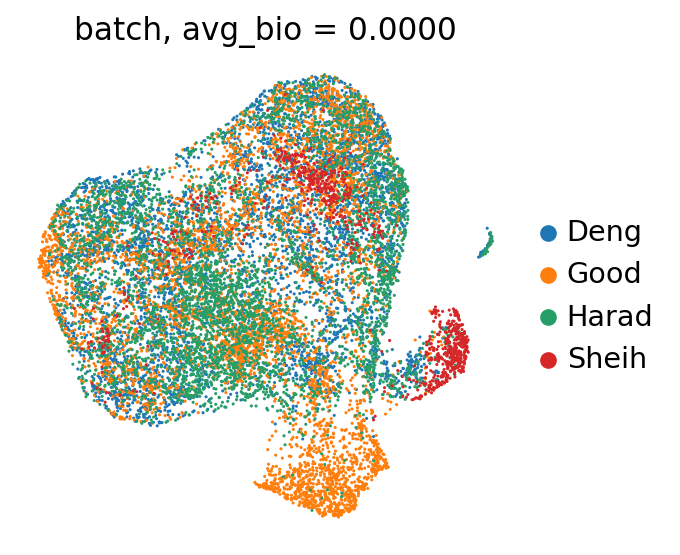

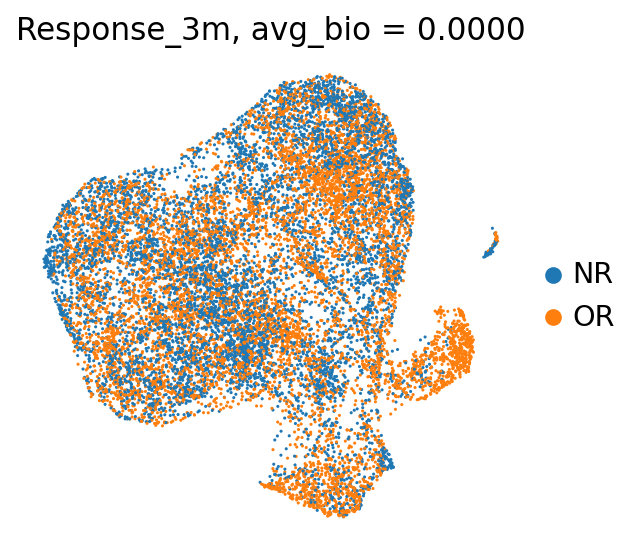

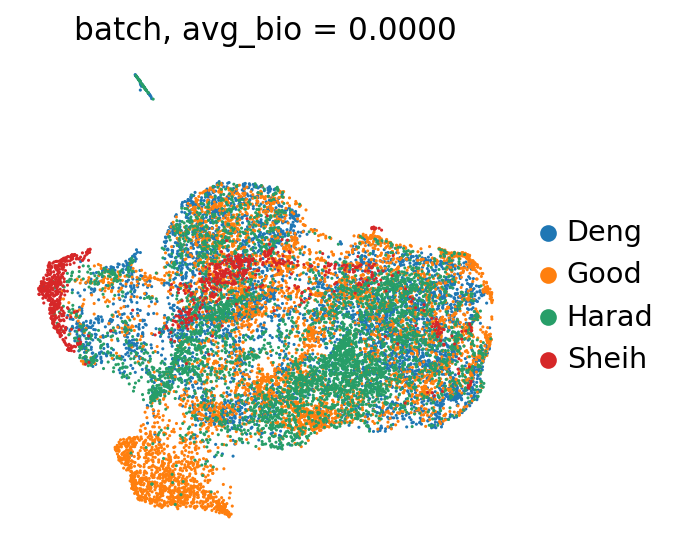

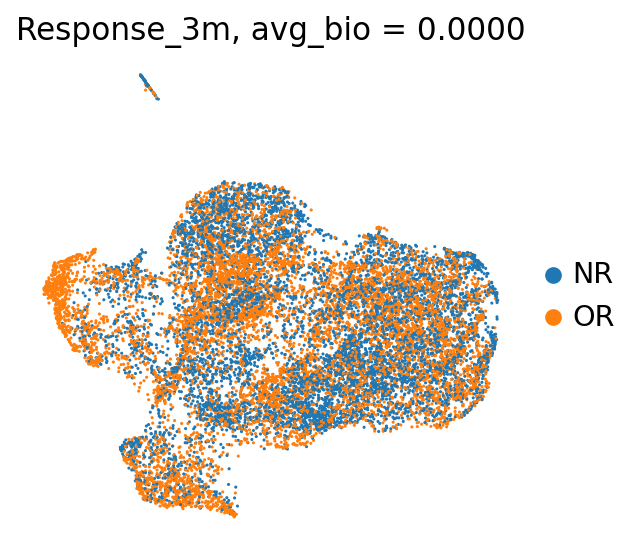

In [25]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            best_model,
            adata_t=adata_sorted if per_seq_batch_sample else adata,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["response_umap"].savefig(
            save_dir / f"embeddings_response_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"response avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/response_umap"] = wandb.Image(
            str(save_dir / f"embeddings_response_umap[cls]_e{best_model_epoch}.png"),
            caption=f"response avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [26]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

In [30]:
any(adata.var.highly_variable == False) 


False

In [48]:
# load the best model
model.load_state_dict(torch.load(save_dir / "best_model.pt"))

<All keys matched successfully>

In [51]:
print(model)

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(4, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dsbn): DomainSpecificBatchNorm1d(
    (bns): ModuleList(
      (0-3): 4 x BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamica

In [52]:
model.encoder.embedding


Embedding(60697, 512, padding_idx=60694)

In [50]:

embedding_weights = best_model.embedding.weight.detach().cpu().numpy()

AttributeError: 'NoneType' object has no attribute 'embedding'

In [46]:
import matplotlib.pyplot as plt
import torch

# Assuming `best_model` is the trained model
embedding_weights = best_model.encoder.embedding.weight.detach().cpu().numpy()

# Save the embedding weights to a file
embedding_file = 'embedding_weights.npy'
np.save(embedding_file, embedding_weights)
# Extract embeddings from the best_model
embeddings = best_model.encoder.embedding.weight.detach().cpu().numpy()

# Plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=5)
plt.title('Embeddings of X_binned')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

AttributeError: 'NoneType' object has no attribute 'encoder'

In [37]:
embeddings.shape

(60697, 512)

In [39]:
adata.X.min(), adata.X.max()    


(0.0, 3051.0)

In [27]:
from pathlib import Path
adata.write(Path.cwd() / "scgpt_batch_corrected_adata.h5ad")


Now trying to use the embedding to train the classifier

In [40]:
def prepare_data(embeddings, labels, train_ratio=0.8, sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    num_samples = embeddings.shape[0]
    num_train = int(train_ratio * num_samples)
    indices = torch.randperm(num_samples)
    train_indices = indices[:num_train]
    valid_indices = indices[num_train:]

    train_data_pt = {
        "embeddings": embeddings[train_indices],
        "labels": labels[train_indices],
    }
    valid_data_pt = {
        "embeddings": embeddings[valid_indices],
        "labels": labels[valid_indices],
    }

    if sort_seq_batch:  # Sort the data if required
        train_sort_ids = torch.argsort(labels[train_indices])
        valid_sort_ids = torch.argsort(labels[valid_indices])
        train_data_pt["embeddings"] = train_data_pt["embeddings"][train_sort_ids]
        train_data_pt["labels"] = train_data_pt["labels"][train_sort_ids]
        valid_data_pt["embeddings"] = valid_data_pt["embeddings"][valid_sort_ids]
        valid_data_pt["labels"] = valid_data_pt["labels"][valid_sort_ids]

    return train_data_pt, valid_data_pt


In [41]:
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # Assuming batch_labels are included in data_pt for this functionality
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


In [43]:
epochs = 2

In [44]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=eval_batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_err = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | err {val_err:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    scheduler.step()
    # if DAB_separate_optim:
    #     scheduler_dab.step()
    # if ADV:
    #     scheduler_D.step()
    #     scheduler_E.step()

TypeError: prepare_data() missing 2 required positional arguments: 'embeddings' and 'labels'

In [ ]:
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

avg_bio,▁█▇
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test/ARI_cluster/label,▁█▇
test/ASW_label,▁█▅
test/ASW_label/batch,█▁▂
test/NMI_cluster/label,▁██
test/PCR_batch,█▄▁
test/avg_bio,▁█▇
test/best_model_epoch,▁▅█
test/graph_conn,▁▃█
train/dab,▁▁▁▁█▃▁▂▃▁▂▁▄▂▁▃▁▁▁▁▃▂▁▃▂▁▂▁▃▂▁▂▂▁▂▁▃▂▁▂


92911